# Informatie uit GEMMA-export importeren in GGM

Dit notebook wordt gebruikt om aanvullende informatie uit een export van de GEMMA te importeren in de beschikbare versie van het [Gemeentelijk Gegevensmodel](https://github.com/Gemeente-Delft/Gemeentelijk-Gegevensmodel). Dit in het kader van de uitwisseling met de GEMMA. Alle beoogde uitwisselingen in het kader van de uitwisseling van het GGM met de GEMMA zijn in onderstaande afbeelding weergegeven.

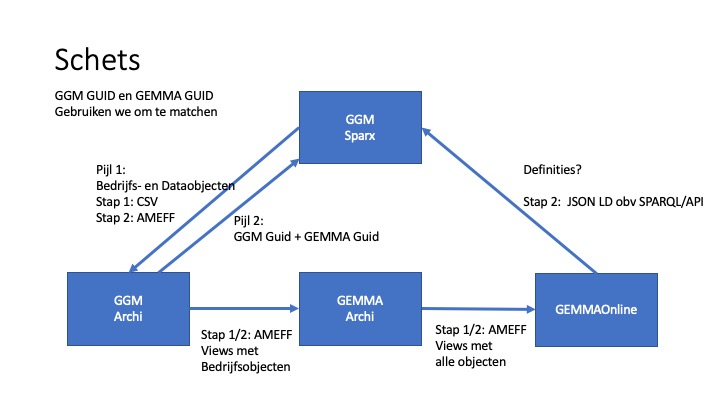

Dit notebook verzorgt de export vanuit het GGM naar de GEMMA conform Pijl 2 in de afbeelding. De gegevens worden geïmporteerd conform de afspraken vastgelegd in [Uitwisseling GGM en GEMMA](https://github.com/Gemeente-Delft/Gemeentelijk-Gegevensmodel/tools/docs/Uitwisseling_GGM_en_GEMMA.pptx) De volgende definities worden geïmporteerd: 

1. objecttypes
2. relaties

## Werking Import

De importmodule maakt gebruik van het feit dat het GGM is vastgelegd in Enterprise Architect van Sparx en dat deze de repository van het GGM in [Sqllite](https://www.sqlite.org/index.html) wordt bijgehouden. Deze importmodule leest de te importeren CSV's uit de GEMMA en de benodigde tabellen uit de repository, voegt ze samen en doet een update op de database.

## Bedrijfsregels Import

Bij het importeren van vanuit GEMMA aangeleverde gegevens worden de volgende regels gehanteerd:

1. Matching vindt plaats op basis van ggm-guid;
2. Alleen gegevens waar een match mogelijk is (Inner join) worden verwerkt;
3. Alle velden waar in de titel 'archimate' of 'gemma' voorkomt overschrijven de reeds in het GGM opgenomen waarde;
4. Definities (Beschrijving van entiteiten) worden overgenomen als het GGM nog geen Definitie aanwezig is.



## Inlezen Objecttypes

Hieronder wordt het model (vanaf 'root_guid' en alles daaronder) ingelezen in het dataframe df voor verdere verwerking. Achtereenvolgens worden de volgende stappen genomen:

1. alle packages (in een tree)
2. alle objecten (classes, enumeraties en waardelijsten) met alle waarden.
3. filteren van objecten op de te exporteren waardes

In [1]:
import datetime

### Configuratie
db_uri = "sqlite://///home/jovyan/root/gemeentelijk gegevensmodel EA16 v2.1.qea"

now = datetime.datetime.now()
dt_string = now.strftime("%d%m%Y-%H:%M:%S")
import_objects = f"./input/GGM-elements-seed.csv"
import_objects = f"https://raw.githubusercontent.com/VNG-Realisatie/GEMMA-GGM-Archi-repository/GGMrondje/CSV%20export/GEMMA_Bedrijfsobjecten_element.csv"
import_relations = f"https://raw.githubusercontent.com/VNG-Realisatie/GEMMA-GGM-Archi-repository/GGMrondje/CSV%20export/GEMMA_Bedrijfsobjecten_relatie.csv"
#import_attributes = f"./input/GGM-properties.csv"

root_guid = '{604AC59D-D038-4e78-A5FA-80E4748DED5B}' #Om te experimenteren: Onderwijs in package ontwikkeling
root_guid = '{45B88627-6F44-4b6d-BE77-3EC51BBE679E}' #Om te experimenteren: Monumenten
root_guid = '{58A5214F-E56C-4707-BE2D-AB36DD6976A3}' #Om te experimenteren: RSGB
root_guid = '{D7FD597E-1F40-48df-AFFC-EA3B5B5D3FBF}' # Root GGM

obj_columns = ['GGM-naam', 'GEMMA-naam', 'GGM-guid', 'GEMMA-guid', 'GEMMA-type', 'GGM-uml-type', 'GGM-definitie', 'GEMMA-definitie', 'GGM-toelichting', 'GEMMA-toelichting', 'GGM-synoniemen', 'GEMMA-synoniemen', 'GGM-bron', 'GEMMA-bron', 'GEMMA-URL', 'GEMMA-alternate-name', 'domein-dcat', 'domein-iv3', 'Datum-tijd-export'] 
obj_column_mapping = {'ea_guid': 'GGM-guid', 'name': 'GGM-naam', 'herkomst': 'GGM-bron', 'objectnote': 'GGM-definitie', 'synoniemen': 'GGM-synoniemen', 'toelichting': 'GGM-toelichting'}
obj_columns_direct = {'definitie'}

con_columns = ['GGM-naam', 'GEMMA-naam', 'GGM-guid', 'GEMMA-guid', 'GEMMA-type', 'GGM-uml-type', 'GGM-definitie', 'GEMMA-definitie', 'GGM-toelichting', 'GEMMA-toelichting', 'GEMMA-source-guid', 'GEMMA-target-guid', 'GGM-source-guid', 'GGM-target-guid', 'datum-tijd-export'] #, 'domein-iv3', 'domein-dcat', 'domein-gemma'] 
con_column_mapping = {'connector_name': 'GGM-naam', 'connector_type': 'GGM-uml-type', 'ea_guid': 'GGM-guid', 'note': 'GGM-definitie', 'ea_guid_source': 'GGM-source-guid', 
                      'ea_guid_target': 'GGM-target-guid', 'toelichting': 'GGM-toelichting'}

#attr_columns = ['naam', 'definitie', 'archimate-datatype', 'uml-datatype', 'gemma-guid', 'ggm-guid', 'gemma-object-guid', 'ggm-object-guid', 'bron', 'toelichting', 'synoniemen', 'datum-tijd-export'] 
#attr_column_mapping = {'name': 'naam', 'type': 'uml-datatype', 'ea_guid': 'ggm-guid', 'ea_guid_object': 'ggm-object-guid', 'herkomst': 'bron', 'notes': 'definitie'}

import_suffix = '_import'

## Configuratie

Met de waarden hieronder configureer je de export. Met root_guid geef je de root in de repository weer waar naartoe (en alles eronder) geïmporteerd wordt. Op deze manier kun je ook naar deelmodellen importeren, en alles negeren dat niet bij dat deelmodel hoort. Als voorbeeld zijn naast de root van het hele GGM ook Onderwijs en monumenten getoond.  

In [2]:
### Importeer bibliotheken en utils

import os
import pandas as pd
import numpy as np
import json
from IPython.display import JSON as JSONDisplay
import requests
import database
import util
from re import sub
import ast
import re
from treelib import Node, Tree
from datetime import datetime
import math 

import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, inspect
from sqlalchemy.engine import reflection
from sqlalchemy.sql.expression import collate

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, Sequence
from sqlalchemy.dialects.postgresql import insert
from sqlalchemy import func
import uuid

def generateEAUUID():
    return '{' +  str(uuid.uuid4()).upper() + '}'

def isEmpty(val):
    if not val:
        return True
    elif pd.isna(val):
        return True
    else:
        return False

def setAtrrIfNotEmpty(obj, prop, val):
    if not isEmpty(val):
        setattr(obj, prop, val)

def setAtrr(obj, prop, val):
    if not isEmpty(val):
        setattr(obj, prop, val)
    else:
        setattr(obj, prop, '')
        
# Gebruik deze om GEMMA-waarden te zetten als er geen GGM-waarde in ingevuld
def getProp(prop, mapper):
    #mapper vertaalt de gebruikte naam naar de property in de repositiry te vertalen 
    reverse_mapper = {value: key for key, value in mapper.items()}
    
    if reverse_mapper.get(prop):
        return reverse_mapper.get(prop)
    else:
        return prop
                

In [3]:
# Alle packages inlezen en omzetten in tree structure

df_package = database.get_df(db_uri, "select * from t_package")
package_tree = util.DataframeToTree(df_package, 'Package_ID', 'Parent_ID', 2)
#tree.show()

In [4]:
#Allereerst alle objectgegevens verzamelen en combineren

# alle objecten (packages, classes, enumeraties en waardelijsten)
df_obj = database.get_df_objectsHierar(db_uri, root_guid=root_guid)
df_obj.dropna(subset='name', inplace=True)

#Packages hebben we niet bodig voor export
df_obj = df_obj[df_obj.object_type != 'Package']

# lees alle object properties. Pivot de verschillede rijen met properties naar een tabel met index Object_ID.
df_objprop = database.get_df(db_uri, 'select * from t_objectproperties')
df_objprop = df_objprop.pivot(index="Object_ID", columns="Property", values="Value")
df_objprop.reset_index(inplace=True)
df_objprop.drop(columns=['Toelichting'], inplace=True)
df_objprop.columns = df_objprop.columns.str.lower()

# Join per object de gevonden property rij
df_obj = df_obj.merge(df_objprop, how='left', on='object_id')


df_obj.head(5)

,object_id,object_type,stereotype,name,alias,author,version,objectnote,ea_guid,modifieddate,...,unieke aanduiding objecttype,unieke aanduiding referentielijst,archimate-type,bron,datum-tijd-export,domein-dcat,domein-gemma,gemma-guid,synoniemen,toelichting
0,12,Class,proxy,Aanwezige Deelnemer,None,Arjen Brienen,1.0,iemand die meedoet aan eencollege- of raadsver...,{F1E55DC7-0F33-40ea-8713-2E1AC3D7EE8D},2024-04-17 13:34:23,...,NaN,NaN,Business object,None,28062023-11:06:06,None,None,id-f1e55dc7-0f33-40ea-8713-2e1ac3d7ee8d,None,None
1,13,Class,None,Agendapunt,None,Arjen Brienen,1.0,Een onderwerp dat in de vergadering wordt beha...,{73FB5212-40ED-40dc-B837-36588840445A},2024-04-17 13:34:24,...,NaN,NaN,Data object,https://www.notuleercentrum.nl/service-voor-no...,28062023-11:06:06,None,None,id-73fb5212-40ed-40dc-b837-36588840445a,None,None
2,14,Class,None,Categorie,None,Arjen Brienen,1.0,Categorie waarop leveranciers zich voor de lev...,{B9B82B25-5D7F-4d2b-84F9-4DF74525EEAD},2024-04-17 13:34:24,...,NaN,NaN,Data object,None,28062023-11:06:06,None,None,id-b9b82b25-5d7f-4d2b-84f9-4df74525eead,None,None
3,15,Class,None,Collegelid,None,Arjen Brienen,1.0,Iemand die behoort het college van burgemeeste...,{7B9EDDFD-57F7-4ff2-938F-FDFA3B503DA8},2024-04-17 13:34:24,...,NaN,NaN,Business object,None,28062023-11:06:06,None,None,id-7b9eddfd-57f7-4ff2-938f-fdfa3b503da8,None,None
4,16,Class,None,Raadscommissie,None,Arjen Brienen,1.0,"<font color=""#191919"">Een raadscommissie binne...",{CB27D699-F82B-45ad-823A-B2B51BCAECBA},2024-04-17 13:43:38,...,NaN,NaN,Business object,https://nl.wikipedia.org/wiki/Commissie,28062023-11:06:06,None,None,id-cb27d699-f82b-45ad-823a-b2b51bcaecba,None,None


In [5]:
## Set the right columns
df_obj_bestaand = util.exportColumns(df_obj, obj_columns, obj_column_mapping)   
df_obj_bestaand['datum-tijd-export'] = dt_string
df_obj_bestaand[df_obj_bestaand['GGM-naam'].fillna('').str.startswith('Balie')].head(5)

,GGM-naam,GGM-guid,GGM-definitie,GGM-toelichting,GGM-synoniemen,GGM-bron,domein-dcat,GEMMA-naam,GEMMA-guid,GEMMA-type,GGM-uml-type,GEMMA-definitie,GEMMA-toelichting,GEMMA-synoniemen,GEMMA-bron,GEMMA-URL,GEMMA-alternate-name,domein-iv3,Datum-tijd-export,datum-tijd-export
160,Balieverkoop,{EA2D32A2-5ED5-45c8-AC33-57C35981B3BC},Verkoop aan de balie,None,None,NaN,None,,,,,,,,,,,,,17042024-12:23:10
161,Balieverkoop Entreekaart,{90E24064-EBB7-4ffc-9640-F7C31678899F},Verkoop van een entreekaart aan de balie,None,None,NaN,None,,,,,,,,,,,,,17042024-12:23:10
615,Balieafspraak,{631FEEF1-88D3-4d18-ADB2-BF999068493E},Balieafspraken zijn afspraken voor een klantco...,Dit ongeacht of deze werkelijk heeft plaatsgev...,None,NaN,None,,,,,,,,,,,,,17042024-12:23:10


## Inlezen CSV met import-informatie over objecten

Eerse wordt CVS ingelezen, en daarna wordt de bestaande data merged met de CSV en worden de waarden uit de kolommen samengevoegd 

In [6]:
df_input = pd.read_csv(import_objects)  

# Fix foutje in aanlevering
df_input.rename(columns={"GEMMA URL": "GEMMA-URL"}, inplace=True)
df_input[df_input['GEMMA-naam'].fillna('').str.startswith('Balie')].head(5)

,GEMMA-naam,GGM-naam,GEMMA-guid,GGM-guid,GEMMA-type,GGM-uml-type,GEMMA-definitie,GGM-definitie,GEMMA-toelichting,GGM-toelichting,GEMMA-synoniemen,GGM-synoniemen,GEMMA-bron,GGM-bron,GEMMA-URL,GEMMA-alternate-name,Datum-tijd-export
102,Balieafspraak,NaN,8fd2ff34-a208-4924-bec3-b5ee7e5e7a18,{631FEEF1-88D3-4d18-ADB2-BF999068493E},business-object,Class,Balieafspraken zijn afspraken voor een klantco...,NaN,Dit ongeacht of deze werkelijk heeft plaatsgev...,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,10-04-2024 17:26:26
179,Balieverkoop,NaN,25088983-e263-4879-8cbb-b699218df32c,{EA2D32A2-5ED5-45c8-AC33-57C35981B3BC},business-object,Class,Verkoop aan de balie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,10-04-2024 17:26:26
344,Balieverkoop Entreekaart,NaN,06763d17-6faa-4c48-b068-e781b72993e0,{90E24064-EBB7-4ffc-9640-F7C31678899F},business-object,Class,Verkoop van een entreekaart aan de balie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,10-04-2024 17:26:26


In [7]:
df_obj_merge = df_obj_bestaand.merge(df_input, how='inner', on='GGM-guid', suffixes=('', import_suffix))
df_obj_merge = df_obj_merge.replace(r'^\s*$', None, regex=True)

df_obj_merge[df_obj_merge['GGM-naam'].fillna('').str.startswith('Balie')].head(5)

,GGM-naam,GGM-guid,GGM-definitie,GGM-toelichting,GGM-synoniemen,GGM-bron,domein-dcat,GEMMA-naam,GEMMA-guid,GEMMA-type,...,GGM-definitie_import,GEMMA-toelichting_import,GGM-toelichting_import,GEMMA-synoniemen_import,GGM-synoniemen_import,GEMMA-bron_import,GGM-bron_import,GEMMA-URL_import,GEMMA-alternate-name_import,Datum-tijd-export_import
99,Balieverkoop,{EA2D32A2-5ED5-45c8-AC33-57C35981B3BC},Verkoop aan de balie,None,None,NaN,NaN,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,10-04-2024 17:26:26
100,Balieverkoop Entreekaart,{90E24064-EBB7-4ffc-9640-F7C31678899F},Verkoop van een entreekaart aan de balie,None,None,NaN,NaN,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,10-04-2024 17:26:26
356,Balieafspraak,{631FEEF1-88D3-4d18-ADB2-BF999068493E},Balieafspraken zijn afspraken voor een klantco...,Dit ongeacht of deze werkelijk heeft plaatsgev...,None,NaN,NaN,None,None,None,...,NaN,Dit ongeacht of deze werkelijk heeft plaatsgev...,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,10-04-2024 17:26:26


In [8]:
cols = df_obj_merge.columns

for col in obj_columns:
    if col in cols and col+import_suffix in cols:
        df_obj_merge[col] = df_obj_merge[col].fillna(df_obj_merge[col+import_suffix])
        if 'GEMMA' in col or 'datum-tijd-export' in col:
            df_obj_merge[col] = df_obj_merge[col+import_suffix]

df_obj_merge[df_obj_merge['GGM-naam'].fillna('').str.startswith('Balie')][obj_columns].head(5)

,GGM-naam,GEMMA-naam,GGM-guid,GEMMA-guid,GEMMA-type,GGM-uml-type,GGM-definitie,GEMMA-definitie,GGM-toelichting,GEMMA-toelichting,GGM-synoniemen,GEMMA-synoniemen,GGM-bron,GEMMA-bron,GEMMA-URL,GEMMA-alternate-name,domein-dcat,domein-iv3,Datum-tijd-export
99,Balieverkoop,Balieverkoop,{EA2D32A2-5ED5-45c8-AC33-57C35981B3BC},25088983-e263-4879-8cbb-b699218df32c,business-object,Class,Verkoop aan de balie,Verkoop aan de balie,NaN,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,NaN,None,10-04-2024 17:26:26
100,Balieverkoop Entreekaart,Balieverkoop Entreekaart,{90E24064-EBB7-4ffc-9640-F7C31678899F},06763d17-6faa-4c48-b068-e781b72993e0,business-object,Class,Verkoop van een entreekaart aan de balie,Verkoop van een entreekaart aan de balie,NaN,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,NaN,None,10-04-2024 17:26:26
356,Balieafspraak,Balieafspraak,{631FEEF1-88D3-4d18-ADB2-BF999068493E},8fd2ff34-a208-4924-bec3-b5ee7e5e7a18,business-object,Class,Balieafspraken zijn afspraken voor een klantco...,Balieafspraken zijn afspraken voor een klantco...,Dit ongeacht of deze werkelijk heeft plaatsgev...,Dit ongeacht of deze werkelijk heeft plaatsgev...,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,NaN,None,10-04-2024 17:26:26


In [9]:
# Vervang eventuele lege GGM-waarden door GEMMA-waarden

# eerst lege strings vervangen door NaN
df_obj_merge = df_obj_merge.replace('', np.nan)

#Nu de waarden zetten
df_obj_merge['GGM-definitie'] = df_obj_merge['GGM-definitie'].fillna(df_obj_merge['GEMMA-definitie'])
df_obj_merge['GGM-toelichting'] = df_obj_merge['GGM-toelichting'].fillna(df_obj_merge['GEMMA-toelichting'])
df_obj_merge['GGM-synoniemen'] = df_obj_merge['GGM-synoniemen'].fillna(df_obj_merge['GEMMA-synoniemen'])
df_obj_merge['GGM-bron'] = df_obj_merge['GGM-bron'].fillna(df_obj_merge['GEMMA-bron'])

df_obj_merge[df_obj_merge['GGM-naam'].fillna('').str.startswith('Balie')][obj_columns].head(5)

,GGM-naam,GEMMA-naam,GGM-guid,GEMMA-guid,GEMMA-type,GGM-uml-type,GGM-definitie,GEMMA-definitie,GGM-toelichting,GEMMA-toelichting,GGM-synoniemen,GEMMA-synoniemen,GGM-bron,GEMMA-bron,GEMMA-URL,GEMMA-alternate-name,domein-dcat,domein-iv3,Datum-tijd-export
99,Balieverkoop,Balieverkoop,{EA2D32A2-5ED5-45c8-AC33-57C35981B3BC},25088983-e263-4879-8cbb-b699218df32c,business-object,Class,Verkoop aan de balie,Verkoop aan de balie,NaN,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,NaN,None,10-04-2024 17:26:26
100,Balieverkoop Entreekaart,Balieverkoop Entreekaart,{90E24064-EBB7-4ffc-9640-F7C31678899F},06763d17-6faa-4c48-b068-e781b72993e0,business-object,Class,Verkoop van een entreekaart aan de balie,Verkoop van een entreekaart aan de balie,NaN,NaN,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,NaN,None,10-04-2024 17:26:26
356,Balieafspraak,Balieafspraak,{631FEEF1-88D3-4d18-ADB2-BF999068493E},8fd2ff34-a208-4924-bec3-b5ee7e5e7a18,business-object,Class,Balieafspraken zijn afspraken voor een klantco...,Balieafspraken zijn afspraken voor een klantco...,Dit ongeacht of deze werkelijk heeft plaatsgev...,Dit ongeacht of deze werkelijk heeft plaatsgev...,NaN,NaN,NaN,NaN,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,NaN,NaN,None,10-04-2024 17:26:26


In [10]:
from sqlalchemy import create_engine, select, MetaData, Table, and_, update, func


def updateSequence(session, sequence):
    t_seq = session.query(Sequence).filter_by(name=sequence).first()
    newval = int(t_seq.seq) + 1
    
    stmt = update(Sequence).where(Sequence.c.name == sequence).values(seq=newval)
    session.execute(stmt)
    return newval
    


# Omzetten algemene packages
# Generic function to set object_types
def saveObjectToDatabase(session, ea_guid, row):
    #print(f'row: {row}')
    t_obj = session.query(Object).filter_by(ea_guid=ea_guid).first()
    #print(f'Changing {row["naam"]}')
    setAtrrIfNotEmpty(t_obj, 'objectnote', row['GGM-definitie'])
    '''
    # Nodig voor MIM
    t_xref = session.query(XRef).filter_by(client=ea_guid, description=mim_text_basismodel).first()
    if not t_xref:
        session.add(XRef(xrefid=generateEAUUID(), name='Stereotypes', type='element property', visibility='Public', partition=0, client=ea_guid, description=mim_text_basismodel))
    '''

    for prop in [item for item in obj_columns if item not in ['GGM-definitie', 'GGM-guid', 'GGM-naam, GGM-uml-type']]:
        eaprop = getProp(prop, obj_column_mapping)
        
        t_objprop = session.query(Objectproperty).filter_by(Object_ID=t_obj.Object_ID, Property=eaprop).first()
        if not t_objprop:
            #print(f'Property: {prop}')
            seq = updateSequence(session, "t_objectproperties")
            session.add(Objectproperty(PropertyID=seq, Object_ID=t_obj.Object_ID, Property=eaprop, Value=str(row[prop]) if not isEmpty(row[prop]) else '', ea_guid=generateEAUUID()))
        else:
            setAtrrIfNotEmpty(t_objprop, 'Value', str(row[prop]))


            
# engine, suppose it has two tables 'user' and 'address' set up
engine = create_engine(db_uri)
metadata = MetaData(bind=None)

# mapped classes are now created with names by default
# matching that of the table name.
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine, reflect=True) #Base.prepare(engine, reflect=True)
Object = Base.classes.t_object
XRef = Base.classes.t_xref

Sequence = Table(
    'sqlite_sequence', 
    metadata, 
    autoload=True, 
    autoload_with=engine
)

#Sequence = Base.classes.sqlite_sequence
Objectproperty = Base.classes.t_objectproperties

# Do transformation
session = Session(engine)



var = None
try:

    session.query(Objectproperty).filter(Objectproperty.Property.like('gemma%')).delete(synchronize_session=False)
        
    for index, row in df_obj_merge.iterrows():
        var = row
        #print(f'index {index}')
        saveObjectToDatabase(session, row['GGM-guid'], row)


    #verwijder oude rommel
    session.query(Objectproperty).filter(Objectproperty.Value.is_(None)).update({'Value': ''}, synchronize_session=False)
    session.query(Objectproperty).filter(Objectproperty.Value == 'nan').update({'Value': ''}, synchronize_session=False)
    session.query(Objectproperty).filter(Objectproperty.Value == 'None').update({'Value': ''}, synchronize_session=False)

    # Selecteer en verwijder rijen waar kolom_x 'archimate' is
    session.query(Objectproperty).filter(Objectproperty.Property == 'archimate-type').delete(synchronize_session=False)
    session.query(Objectproperty).filter(Objectproperty.Property == 'GGM-uml-type').delete(synchronize_session=False)
    session.query(Objectproperty).filter(Objectproperty.Property == 'Bron').delete(synchronize_session=False)
    session.query(Objectproperty).filter(Objectproperty.Property == 'Bron ID').delete(synchronize_session=False)
    
    #
    
    
except:
    print(f'Foutmelding {row}')
    raise
        
finally:
    session.commit()
    engine.dispose()
    


## Inlezen Relatiesoorten

Hieronder wordt het model (vanaf 'root_guid' en alles daaronder) ingelezen in het dataframe df voor verdere verwerking. Achtereenvolgens worden de volgende stappen genomen:

1. alle connecties inlezen
2. koppelen source en dest objecten
3. alle properties inlezen en koppelen
4. filteren op te exporteren waardes

In [11]:
# inlezen alle relaties bij deze objecten
# alle relaties (associaties en generatiesaties) die bij start of einde een object uit de subset hebben worden meegenomen

df_con = database.get_df(db_uri, database.sql_connectors).rename(columns={'connector_ea_guid':'ea_guid'})
df_con = df_con.merge(df_obj[['object_id', 'ea_guid']], right_on='object_id', left_on='start_object_id', how='inner', suffixes=['', '_source'])
df_con = df_con.merge(df_obj[['object_id', 'ea_guid']], right_on='object_id', left_on='end_object_id', how='inner', suffixes=['', '_target'])
df_con.drop_duplicates('connector_id', inplace=True)


# lees alle relatie properties. Pivot de verschillede rijen met properties naar een tabel met index Element_ID.
df_conprop = database.get_df(db_uri, 'select * from t_connectortag')
df_conprop = df_conprop.pivot(index="ElementID", columns="Property", values="VALUE")
df_conprop.reset_index(inplace=True)
df_conprop.columns = df_conprop.columns.str.lower()

# Join per object de gevonden property rij
df_con = df_con.merge(df_conprop, how='left', left_on='connector_id', right_on='elementid')
df_con.head(5)

,connector_name,connector_type,start_object_id,end_object_id,connector_sourcecard,connector_destcard,connector_sourcerole,connector_destrole,top_start_label,top_mid_label,...,indicatie authentiek,indicatie formele historie,indicatie in onderzoek,indicatie materiële historie,mogelijk geen waarde,naam terugrelatie,regels,regels relatiesoort,toelichting,toelichting relatiesoort
0,naam4,Association,1322,1324,0..*,1,None,None,None,naam4,...,Aanduiding of de attribuutsoort waarvan de rel...,None,None,None,Nee,NaN,<memo>,NaN,<memo>,NaN
1,naam3,Association,1322,1323,0..*,1,None,None,None,naam3,...,Aanduiding of de attribuutsoort waarvan de rel...,None,None,None,Nee,NaN,<memo>,NaN,<memo>,NaN
2,naam2 (werkwoord),Association,1321,1319,0..*,1..*,None,None,None,naam2 (werkwoord),...,Aanduiding of de attribuutsoort waarvan de rel...,None,None,None,Nee,NaN,<memo>,NaN,<memo>,NaN
3,naam1 (werkwoord),Association,1318,1319,1,0..*,None,None,None,naam1 (werkwoord),...,Aanduiding of de attribuutsoort waarvan de rel...,None,None,None,Nee,NaN,<memo>,NaN,<memo>,NaN
4,is specialisatie van,Generalization,1318,1320,None,None,None,None,None,is specialisatie van,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
'''
Check columns zoals afgesproken in Powerpoint

*naam (label)
*definitie
*toelichting
*ggm-guid
*ggm-source-guid
*ggm-target-guid
*gemma-guid
*gemma-source-guid
*gemma-target-guid
*uml-type ( Associatie, Generalisatie, Aggregatie)
*archimate-type (Association, Generalisatie, Aggregation)
*datum-tijd-export (ddmmyyyy-hh:mm:ss)
'''

df_con_bestaand = util.exportColumns(df_con, con_columns, con_column_mapping)    
df_con_bestaand = df_con_bestaand.loc[:,~df_con_bestaand.columns.duplicated()].copy()
df_con_bestaand['datum-tijd-export'] = dt_string
df_con_bestaand.head(5)

,GGM-naam,GGM-guid,GGM-uml-type,GGM-definitie,GGM-toelichting,GGM-source-guid,GGM-target-guid,GEMMA-naam,GEMMA-guid,GEMMA-type,GEMMA-definitie,GEMMA-toelichting,GEMMA-source-guid,GEMMA-target-guid,datum-tijd-export
0,naam4,{476E7F9D-D7F2-4279-B35B-981DCDA389E0},Association,None,<memo>,{EF4E7B58-F178-4a4f-85C5-A5CD93747A36},{97EE5348-F06A-44cb-A792-7371CF5D2E53},,,,,,,,17042024-12:23:10
1,naam3,{EB1ECE1C-9867-46d8-B423-50862C0A344A},Association,None,<memo>,{EF4E7B58-F178-4a4f-85C5-A5CD93747A36},{23D170D0-917E-4873-A622-43214405AB3D},,,,,,,,17042024-12:23:10
2,naam2 (werkwoord),{18883E50-FEE4-4c26-A82E-28BB87F53C62},Association,None,<memo>,{DE4D6CAB-7798-46cd-AE1B-328684681323},{0799B0D1-5067-43e2-8A6F-48FB972225E5},,,,,,,,17042024-12:23:10
3,naam1 (werkwoord),{3F495D53-B1CF-4dda-A6CA-903B2ECC735F},Association,None,<memo>,{AE553F3F-B8B6-4bd2-A6A1-8051145C823B},{0799B0D1-5067-43e2-8A6F-48FB972225E5},,,,,,,,17042024-12:23:10
4,is specialisatie van,{CA4EDB07-778F-42c4-85ED-A5FE4AF8B21F},Generalization,None,NaN,{AE553F3F-B8B6-4bd2-A6A1-8051145C823B},{889A7DC6-B389-4e02-BB53-CC0B2B5B0D91},,,,,,,,17042024-12:23:10


## Inlezen CSV met import-informatie over objecten

Eerse wordt CSV ingelezen, en daarna wordt de bestaande data merged met de CSV en worden de waarden uit de kolommen samengevoegd 

In [13]:
df_input = pd.read_csv(import_relations)  
df_input.head(5)

,GEMMA-naam,GGM-naam,GEMMA-guid,GGM-guid,GEMMA-type,GGM-uml-type,GEMMA-definitie,GGM-definitie,GEMMA-toelichting,GGM-toelichting,GEMMA-source-guid,GEMMA-target-guid,Datum-tijd-export
0,heeft maatregel,NaN,9aaea699-9949-405b-9fca-efbfbd1989f8,{68D387CF-74AA-4219-8B64-52D7FE6A8DC5},association-relationship,Association,NaN,NaN,NaN,NaN,8c200706-b80b-44f7-9928-bec39e0db21f,fd61984f-002e-465f-90c7-6a68cc692094,10-04-2024 17:26:26
1,heeft verzuim,NaN,7b47f9d0-02cf-486b-a153-dfebe31b2f23,{7702C4F6-A0C5-44d0-9857-96B1F62FD27F},association-relationship,Association,NaN,NaN,NaN,NaN,8c200706-b80b-44f7-9928-bec39e0db21f,c024eb06-53f7-4793-91d6-6e249ee119dc,10-04-2024 17:26:26
2,heeft verlof,NaN,5342d9d1-5bd3-46bc-a78f-e9bd9b053643,{A4816678-4407-46e7-B5EC-2FEAB323A83A},association-relationship,Association,NaN,NaN,NaN,NaN,8c200706-b80b-44f7-9928-bec39e0db21f,9ba143bc-5214-4998-9041-b3dc1c22fe77,10-04-2024 17:26:26
3,Beoordeelt door,NaN,047440e9-3ec3-42c0-883b-2aae7f6fa3de,{24BF4DCE-5DDC-4c1b-92F0-EFADF4BE03B9},association-relationship,Association,NaN,NaN,NaN,NaN,8c200706-b80b-44f7-9928-bec39e0db21f,2f8612e6-df55-40f2-a8d1-e51b22b5cf9d,10-04-2024 17:26:26
4,heeft ondergaan,NaN,df17958e-39e0-4dfa-997f-07fb77590046,{8AF83985-ABFC-4a38-95D3-CB368AA680BA},association-relationship,Association,NaN,NaN,NaN,NaN,8c200706-b80b-44f7-9928-bec39e0db21f,fddeb5c4-571e-45ec-8bde-86cc9702ff18,10-04-2024 17:26:26


In [14]:
df_con_merge = df_con_bestaand.merge(df_input, how='inner', on='GGM-guid', suffixes=('', import_suffix))
df_con_merge = df_con_merge.replace(r'^\s*$', None, regex=True)
df_con_merge.head(5)


,GGM-naam,GGM-guid,GGM-uml-type,GGM-definitie,GGM-toelichting,GGM-source-guid,GGM-target-guid,GEMMA-naam,GEMMA-guid,GEMMA-type,...,GEMMA-guid_import,GEMMA-type_import,GGM-uml-type_import,GEMMA-definitie_import,GGM-definitie_import,GEMMA-toelichting_import,GGM-toelichting_import,GEMMA-source-guid_import,GEMMA-target-guid_import,Datum-tijd-export
0,is belast met,{BA508E5B-A499-4ff8-91A5-37368D6C0481},Association,Verwijzing naar het ZAKELIJK RECHT waarmee het...,<memo>,{8C809341-AC60-4378-8BA0-0843E8C06AF3},{8C809341-AC60-4378-8BA0-0843E8C06AF3},None,None,None,...,5f3d1ae7-22ec-491f-80f4-041d895cbadd,association-relationship,Association,Verwijzing naar het ZAKELIJK RECHT waarmee het...,NaN,<memo>,NaN,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,10-04-2024 17:26:26
1,heeft betrekking op,{37F7170A-15AE-4bf3-9042-193E6084A3E8},Association,Een verwijzing naar het recht dat door een per...,<memo>,{2651D6E0-6AC8-43a8-A4F6-4706209BAC8E},{8C809341-AC60-4378-8BA0-0843E8C06AF3},None,None,None,...,9f95c45c-5e5a-4e80-8f5d-37b204a91e40,association-relationship,Association,Een verwijzing naar het recht dat door een per...,NaN,<memo>,NaN,429cbd2f-a86d-49d9-9c8a-0de67a7e7d3e,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,10-04-2024 17:26:26
2,None,{6B2C12F4-9570-41fc-A6D5-620F57C33612},Generalization,None,NaN,{8D52E9F1-9CC9-42c6-A347-E68E29718E55},{8C809341-AC60-4378-8BA0-0843E8C06AF3},None,None,None,...,bd1b74f0-9210-4411-b01a-9e5cd9d94718,specialization-relationship,Generalization,NaN,NaN,NaN,NaN,a6741440-a70f-4d05-b164-6a21b867b4d3,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,10-04-2024 17:26:26
3,heeft betrekking op,{1A349697-B524-49b7-B513-DEC2BA5ACE19},Association,None,NaN,{5DC6EA71-272C-4392-BA5E-5C97DC3CA9D9},{8C809341-AC60-4378-8BA0-0843E8C06AF3},None,None,None,...,bb522ffd-6442-4514-83b1-bd03cb5d638d,association-relationship,Association,NaN,NaN,NaN,NaN,4c80e4c9-5e35-43d8-8438-2860c18949f0,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,10-04-2024 17:26:26
4,is beperkt tot,{F9F7F2FF-30E9-49b4-B5B6-9B4FB86E8500},Association,Verwijzing naar de TENAAMSTELLING waarop het ...,<memo>,{8C809341-AC60-4378-8BA0-0843E8C06AF3},{2651D6E0-6AC8-43a8-A4F6-4706209BAC8E},None,None,None,...,e47573a3-744f-4bcf-96da-33a0ba01811a,association-relationship,Association,Verwijzing naar de TENAAMSTELLING waarop het ...,NaN,<memo>,NaN,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,429cbd2f-a86d-49d9-9c8a-0de67a7e7d3e,10-04-2024 17:26:26


In [15]:
cols = list(df_con_merge.columns)

for col in con_columns:
    if col in cols and col+import_suffix in cols:
        df_con_merge[col] = df_con_merge[col].fillna(df_con_merge[col+import_suffix])
        if 'GEMMA' in col or 'datum-tijd-export' in col:
            df_con_merge[col] = df_con_merge[col+import_suffix]

df_con_merge[con_columns]

,GGM-naam,GEMMA-naam,GGM-guid,GEMMA-guid,GEMMA-type,GGM-uml-type,GGM-definitie,GEMMA-definitie,GGM-toelichting,GEMMA-toelichting,GEMMA-source-guid,GEMMA-target-guid,GGM-source-guid,GGM-target-guid,datum-tijd-export
0,is belast met,is belast met,{BA508E5B-A499-4ff8-91A5-37368D6C0481},5f3d1ae7-22ec-491f-80f4-041d895cbadd,association-relationship,Association,Verwijzing naar het ZAKELIJK RECHT waarmee het...,Verwijzing naar het ZAKELIJK RECHT waarmee het...,<memo>,<memo>,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,{8C809341-AC60-4378-8BA0-0843E8C06AF3},{8C809341-AC60-4378-8BA0-0843E8C06AF3},17042024-12:23:10
1,heeft betrekking op,heeft betrekking op,{37F7170A-15AE-4bf3-9042-193E6084A3E8},9f95c45c-5e5a-4e80-8f5d-37b204a91e40,association-relationship,Association,Een verwijzing naar het recht dat door een per...,Een verwijzing naar het recht dat door een per...,<memo>,<memo>,429cbd2f-a86d-49d9-9c8a-0de67a7e7d3e,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,{2651D6E0-6AC8-43a8-A4F6-4706209BAC8E},{8C809341-AC60-4378-8BA0-0843E8C06AF3},17042024-12:23:10
2,NaN,NaN,{6B2C12F4-9570-41fc-A6D5-620F57C33612},bd1b74f0-9210-4411-b01a-9e5cd9d94718,specialization-relationship,Generalization,NaN,NaN,NaN,NaN,a6741440-a70f-4d05-b164-6a21b867b4d3,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,{8D52E9F1-9CC9-42c6-A347-E68E29718E55},{8C809341-AC60-4378-8BA0-0843E8C06AF3},17042024-12:23:10
3,heeft betrekking op,heeft betrekking op,{1A349697-B524-49b7-B513-DEC2BA5ACE19},bb522ffd-6442-4514-83b1-bd03cb5d638d,association-relationship,Association,NaN,NaN,NaN,NaN,4c80e4c9-5e35-43d8-8438-2860c18949f0,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,{5DC6EA71-272C-4392-BA5E-5C97DC3CA9D9},{8C809341-AC60-4378-8BA0-0843E8C06AF3},17042024-12:23:10
4,is beperkt tot,is beperkt tot,{F9F7F2FF-30E9-49b4-B5B6-9B4FB86E8500},e47573a3-744f-4bcf-96da-33a0ba01811a,association-relationship,Association,Verwijzing naar de TENAAMSTELLING waarop het ...,Verwijzing naar de TENAAMSTELLING waarop het ...,<memo>,<memo>,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,429cbd2f-a86d-49d9-9c8a-0de67a7e7d3e,{8C809341-AC60-4378-8BA0-0843E8C06AF3},{2651D6E0-6AC8-43a8-A4F6-4706209BAC8E},17042024-12:23:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,NaN,NaN,{12B5F13C-51AA-4cae-A23E-439F1EE85110},6bece7e9-b8fe-4acb-8f34-24139221b795,specialization-relationship,Generalization,NaN,NaN,NaN,NaN,c92e9c16-1ec3-46f8-b209-b15a226e9477,b2498fa2-f9ff-48dd-946d-8b8ed395da81,{8587D910-7A9C-46d8-BF27-27433E9B6DAD},{10C06EB3-F94A-4005-9C66-0DAE61B96192},17042024-12:23:10
636,NaN,NaN,{1B9439BF-6E55-4046-AA5F-66B5697C9CE3},0a30fb52-8cf6-4711-9f58-1b02b84c7076,specialization-relationship,Generalization,NaN,NaN,NaN,NaN,16995484-0391-40d1-99c3-2ba2292e276f,b2498fa2-f9ff-48dd-946d-8b8ed395da81,{C2A7756C-87E9-44f0-85A9-673F3956BB48},{10C06EB3-F94A-4005-9C66-0DAE61B96192},17042024-12:23:10
637,NaN,NaN,{AF7F4C05-D98D-4ddb-A0FE-F0361A1F9546},fe1d665c-9137-461b-81a1-8d7f41309ab6,specialization-relationship,Generalization,NaN,NaN,NaN,NaN,7685ae20-7bed-4f7e-95fd-3499b35a6ef9,71c5f929-bbab-484f-96c0-cc7a57c9dcf1,{6B1F7274-19A7-4349-835E-85CBEFFEE35A},{081F7413-A4D0-49e7-98E2-E0F3F4299750},17042024-12:23:10
638,NaN,NaN,{7C0BE110-2B2C-4e39-A8B8-EF105FBC6FA4},5f009095-a883-4c7e-9640-7979752fb1b9,specialization-relationship,Generalization,NaN,NaN,NaN,NaN,bbf6bcce-f2dc-4b8d-95a8-561abd7c1d76,71c5f929-bbab-484f-96c0-cc7a57c9dcf1,{F90F8E5E-7402-4c44-AC69-91A4175E5D47},{081F7413-A4D0-49e7-98E2-E0F3F4299750},17042024-12:23:10


In [16]:
# Vervang eventuele lege GGM-waarden door GEMMA-waarden

# eerst lege strings vervangen door NaN
df_con_merge = df_con_merge.replace('', np.nan)

#Nu de waarden zetten
df_con_merge['GGM-definitie'] = df_con_merge['GGM-definitie'].fillna(df_con_merge['GEMMA-definitie'])
df_con_merge['GGM-toelichting'] = df_con_merge['GGM-toelichting'].fillna(df_con_merge['GEMMA-toelichting'])

df_con_merge.head(5)

,GGM-naam,GGM-guid,GGM-uml-type,GGM-definitie,GGM-toelichting,GGM-source-guid,GGM-target-guid,GEMMA-naam,GEMMA-guid,GEMMA-type,...,GEMMA-guid_import,GEMMA-type_import,GGM-uml-type_import,GEMMA-definitie_import,GGM-definitie_import,GEMMA-toelichting_import,GGM-toelichting_import,GEMMA-source-guid_import,GEMMA-target-guid_import,Datum-tijd-export
0,is belast met,{BA508E5B-A499-4ff8-91A5-37368D6C0481},Association,Verwijzing naar het ZAKELIJK RECHT waarmee het...,<memo>,{8C809341-AC60-4378-8BA0-0843E8C06AF3},{8C809341-AC60-4378-8BA0-0843E8C06AF3},is belast met,5f3d1ae7-22ec-491f-80f4-041d895cbadd,association-relationship,...,5f3d1ae7-22ec-491f-80f4-041d895cbadd,association-relationship,Association,Verwijzing naar het ZAKELIJK RECHT waarmee het...,NaN,<memo>,NaN,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,10-04-2024 17:26:26
1,heeft betrekking op,{37F7170A-15AE-4bf3-9042-193E6084A3E8},Association,Een verwijzing naar het recht dat door een per...,<memo>,{2651D6E0-6AC8-43a8-A4F6-4706209BAC8E},{8C809341-AC60-4378-8BA0-0843E8C06AF3},heeft betrekking op,9f95c45c-5e5a-4e80-8f5d-37b204a91e40,association-relationship,...,9f95c45c-5e5a-4e80-8f5d-37b204a91e40,association-relationship,Association,Een verwijzing naar het recht dat door een per...,NaN,<memo>,NaN,429cbd2f-a86d-49d9-9c8a-0de67a7e7d3e,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,10-04-2024 17:26:26
2,NaN,{6B2C12F4-9570-41fc-A6D5-620F57C33612},Generalization,NaN,NaN,{8D52E9F1-9CC9-42c6-A347-E68E29718E55},{8C809341-AC60-4378-8BA0-0843E8C06AF3},NaN,bd1b74f0-9210-4411-b01a-9e5cd9d94718,specialization-relationship,...,bd1b74f0-9210-4411-b01a-9e5cd9d94718,specialization-relationship,Generalization,NaN,NaN,NaN,NaN,a6741440-a70f-4d05-b164-6a21b867b4d3,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,10-04-2024 17:26:26
3,heeft betrekking op,{1A349697-B524-49b7-B513-DEC2BA5ACE19},Association,NaN,NaN,{5DC6EA71-272C-4392-BA5E-5C97DC3CA9D9},{8C809341-AC60-4378-8BA0-0843E8C06AF3},heeft betrekking op,bb522ffd-6442-4514-83b1-bd03cb5d638d,association-relationship,...,bb522ffd-6442-4514-83b1-bd03cb5d638d,association-relationship,Association,NaN,NaN,NaN,NaN,4c80e4c9-5e35-43d8-8438-2860c18949f0,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,10-04-2024 17:26:26
4,is beperkt tot,{F9F7F2FF-30E9-49b4-B5B6-9B4FB86E8500},Association,Verwijzing naar de TENAAMSTELLING waarop het ...,<memo>,{8C809341-AC60-4378-8BA0-0843E8C06AF3},{2651D6E0-6AC8-43a8-A4F6-4706209BAC8E},is beperkt tot,e47573a3-744f-4bcf-96da-33a0ba01811a,association-relationship,...,e47573a3-744f-4bcf-96da-33a0ba01811a,association-relationship,Association,Verwijzing naar de TENAAMSTELLING waarop het ...,NaN,<memo>,NaN,671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f,429cbd2f-a86d-49d9-9c8a-0de67a7e7d3e,10-04-2024 17:26:26


In [17]:
from sqlalchemy import create_engine, select, MetaData, Table, and_, update

def updateSequence(session, sequence):
    t_seq = session.query(Sequence).filter_by(name=sequence).first()
    newval = int(t_seq.seq) + 1
    
    stmt = update(Sequence).where(Sequence.c.name == sequence).values(seq=newval)
    session.execute(stmt)
    return newval
    
    

# Generic function to set object_types
def changeConnector(session, ea_guid, row):
    t_rel = session.query(Connector).filter_by(ea_guid=ea_guid).first()
    if t_rel:
        setAtrrIfNotEmpty(t_rel, 'note', row['GGM-definitie'])

        '''
        Nodig voor MIM
        t_xref = session.query(XRef).filter_by(client=ea_guid, description=mim_text).first()
        if not t_xref:
            session.add(XRef(xrefid=generateEAUUID(), name='Stereotypes', type='element property', visibility='Public', partition=0, client=ea_guid, description=mim_text))
        '''

        for prop in [item for item in con_columns if item not in ['GGM-definitie', 'GGM-guid', 'GGM-source-guid', 'GGM-target-guid', 'GGM-uml-type', 'GGM-naam']]:
            eaprop = getProp(prop, con_column_mapping)
            
            t_relprop = session.query(ConnectorTag).filter_by(ElementID=t_rel.Connector_ID, Property=eaprop).first()
            if not t_relprop:
                seq = updateSequence(session, "t_connectortag")
                #new_id = engine.execute(Sequence('propertyid_seq'))
                session.add(ConnectorTag(PropertyID=seq, ElementID=t_rel.Connector_ID, Property=eaprop, VALUE=str(row[prop]) if not isEmpty(row[prop]) else '', ea_guid=generateEAUUID()))
            else: 
                setAtrrIfNotEmpty(t_relprop, 'VALUE', str(row[prop]))

        #print(f'Changing Connector {t_rel.name} type: {relatie_type}')
        
        
            
# engine, suppose it has two tables 'user' and 'address' set up
engine = create_engine(db_uri)
metadata = MetaData(bind=None)

# mapped classes are now created with names by default
# matching that of the table name.
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine, reflect=True) #Base.prepare(engine, reflect=True)
Connector = Base.classes.t_connector
XRef = Base.classes.t_xref
ConnectorTag = Base.classes.t_connectortag

Sequence = Table(
    'sqlite_sequence', 
    metadata, 
    autoload=True, 
    autoload_with=engine
)

#Sequence = Base.classes.sqlite_sequence

    
session = Session(engine)
try:
    for index, row in df_con_merge.iterrows():
        changeConnector(session, row['GGM-guid'], row)
except:
    raise    
finally:
    session.commit()
    engine.dispose()
    
